In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

plt.style.use('ggplot')

# **Cleaning the Data**

The first dataset I have loaded is from the GISS Surface Temperature Analysis version 4 (GISTEMP v4), an estimate of global surface temperature change. The values under each month column are the monthly mean deviation from an average value. For each month, the average value is simply the mean of the monthly average temperatures from the years 1951 to 1980. 

The second dataset is the PRIMAP-hist national historical emissions time series (1750-2021).

## **GISS Data**

In [3]:
gw_temp_df = pd.read_csv('./GLB.Ts+dSST.csv', sep='\t')

In [4]:
column_names = gw_temp_df.iloc[0].str.split(',').explode().tolist()
new_df = pd.DataFrame(columns=column_names)

In [5]:
data_df = gw_temp_df.iloc[1:]

for index, row in data_df.iterrows():
    raw_data = row.str.split(',').explode().tolist()
    raw_data_df = pd.DataFrame([raw_data], columns=new_df.columns)
    new_df = pd.concat([new_df, raw_data_df], ignore_index=True)

In [6]:
new_df = new_df[new_df['Year'] < '2023']
new_df = new_df.replace('***', np.nan)

In [7]:
new_df.Year = new_df.Year.astype('int')

In [8]:
float_cols = [col for col in new_df.columns if col != 'Year']
for col in float_cols:
    new_df[col] = new_df[col].astype('float')

In [9]:
monthly_data = new_df.iloc[:,0:13]

## **Historical Greenhouse Gas Emission Data**

In [10]:
ghg_raw_df = pd.read_csv('./Guetschow-et-al-2023a-PRIMAP-hist_v2.4.2_final_09-Mar-2023.csv')

In [11]:
cols_to_keep = [col for col in ghg_raw_df.columns if col not in ['source', 'scenario (PRIMAP-hist)', 'unit', 'category (IPCC2006_PRIMAP)']]
ghg_filtered_df = ghg_raw_df[cols_to_keep]

In [12]:
ghg_grouped = ghg_filtered_df.groupby('entity').sum()
ghg_grouped.reset_index(inplace=True)

/var/folders/3s/6yq71yf16yq1y9c5zlss3syc0000gn/T/ipykernel_47691/1526667985.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ghg_grouped = ghg_filtered_df.groupby('entity').sum()


In [13]:
melted_df = ghg_grouped.melt(id_vars=['entity'], var_name='Year', value_name='Value')
reshaped_df = melted_df.pivot(index='Year', columns='entity', values='Value')
ghg_df = reshaped_df.reset_index()

In [39]:
ghg_df.Year = ghg_df.Year.astype('int')

# **Are Temperatures Rising?**

Here, I wish to explore a simple narrative- is the globe getting hotter?
The first thing that I would have to do is check the distributions and trends in my temperature data.

In [83]:
def update_histogram(selected_month):
    plt.figure(figsize=(8, 6))
    # Calculate the average year for each bin
    bin_means, bin_edges, _ = plt.hist(monthly_data[selected_month], bins='auto', edgecolor='black')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    avg_years = [monthly_data.loc[(monthly_data[selected_month] >= edge_left) &
                                  (monthly_data[selected_month] < edge_right), 'Year'].mean()
                 for edge_left, edge_right in zip(bin_edges[:-1], bin_edges[1:])]

    # Create a colormap
    cmap = plt.get_cmap('hot')
    norm = plt.Normalize(min(avg_years), max(avg_years))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.bar(bin_centers, bin_means, width=np.diff(bin_edges), color=cmap(norm(avg_years)))
    ax = plt.gca()
    cbar = plt.colorbar(sm, ax=ax)  # Provide the ax argument
    cbar.set_label('Average Year')

    plt.title(f'Temperature Anomaly Histogram for {selected_month}')
    plt.xlabel('Temperature Anomaly')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

month_columns = monthly_data.columns[1:]
month_selector = widgets.Dropdown(
    options=month_columns,
    description='Select Month:',
    disabled=False
)

output_plot = widgets.Output()

def on_month_change(change):
    selected_month = change.new
    with output_plot:
        output_plot.clear_output()
        update_histogram(selected_month)

month_selector.observe(on_month_change, names='value')

display(month_selector)
display(output_plot)

Dropdown(description='Select Month:', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', …

Output()

As we can see, with clear certainty, the higher temperature anomalies tend to correspond to later years. Let's delve into this a little more by looking at the monthly average temperatures over the years.

In [84]:
def update_line_plot(selected_month):
    plt.figure(figsize=(8, 6))
    y_values = monthly_data[selected_month]
    plt.plot(monthly_data['Year'], y_values, marker='o')
    plt.title(f'Temperature Anomaly vs. Year for {selected_month}')
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly')
    plt.grid(True)
    plt.show()

month_columns = monthly_data.columns[1:]
month_selector = widgets.Dropdown(
    options=month_columns,
    description='Select Month:',
    disabled=False
)

output_plot = widgets.Output()

def on_month_change(change):
    selected_month = change.new
    with output_plot:
        output_plot.clear_output()
        update_line_plot(selected_month)

month_selector.observe(on_month_change, names='value')

display(month_selector)
display(output_plot)

Dropdown(description='Select Month:', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', …

Output()

Given the previous graphs, I think we can conclude with some certainty that the average temperature per month has gotten hotter. Let's quantify that by calculating what the correlation coefficients are.

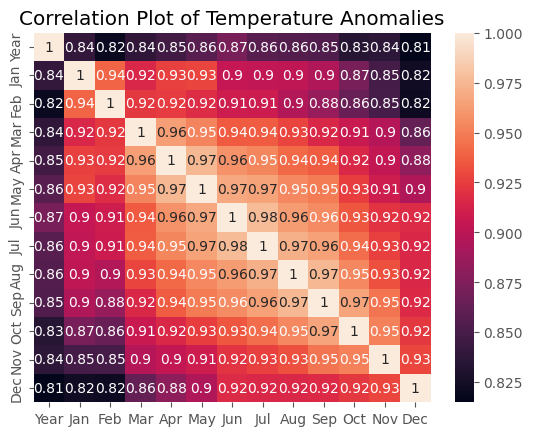

In [18]:
sns.heatmap(monthly_data.corr(), annot=True)
plt.title(f'Correlation Plot of Temperature Anomalies')
plt.show()

What insights can we gain from this heatmap? Firstly, we can see that the coefficients around the 1's down the diagonal are higher than the ones further away. This gives credence to the notion that if one month is particularly hot, then the next month would be as well. Secondly, we can see that while there is only minor variation in the correlation of Year to the monthly anomalies by month, the correlation seems to peak in June, at .87. Finally, we can see that all of the correlation coefficients for year vs month are above .80, which implies that there is very strong correlation between an increasing 'Year' value and an increasing monthly temperature anomaly value.

In this section, I think we have successfully seen that the global temperatures are rising from where they were in the past. Now, we should try to analyze various features of the line plots we saw above-
 What is causing the current rise in temperature?

# **Greenhouse Gas Emissions**

Now that we have seen that temperatures are rising, let us check the effect of the most commonly cited source: greenhouse gas emissions.

In [85]:
def update_line_plot(selected_col):
    plt.figure(figsize=(8, 6))
    y_values = ghg_df[selected_col]
    y_units = ghg_raw_df[ghg_raw_df['entity']==selected_col].unit.iloc[0]
    plt.plot(ghg_df['Year'], y_values)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(MultipleLocator(10))  # Display every 5th x-axis tick label
    plt.title(f'Emissions vs. Year for {selected_col}')
    plt.xlabel('Year')
    plt.ylabel(f'{selected_col} Emissions ({y_units})')
    plt.grid(True)
    plt.show()

gas_columns = ghg_df.columns[1:]
gas_selector = widgets.Dropdown(
    options=gas_columns,
    description='Select gas:',
    disabled=False
)

output_plot = widgets.Output()

def on_gas_change(change):
    selected_col = change.new
    with output_plot:
        output_plot.clear_output()
        update_line_plot(selected_col)

gas_selector.observe(on_gas_change, names='value')

display(gas_selector)
display(output_plot)

Dropdown(description='Select gas:', options=('CH4', 'CO2', 'FGASES (AR4GWP100)', 'FGASES (SARGWP100)', 'HFCS (…

Output()

## **What is driving the current rise in temperatures?**

We know that at the beginning of the Industrial Revolution, the main source of energy was coal. The main greenhouse gas emitted in burning coal is CO2. This graph marks up nicely with our plots of Temperature anomaly vs Year. Let's make a scatterplot of the monthly temperature anomaly with CO2 emissions.

In [42]:
ghg_limited = ghg_df[ghg_df['Year']>1879]
monthly_limited = monthly_data[monthly_data['Year']<2022]

In [86]:

def update_scatter_plot(selected_month):
    plt.figure(figsize=(8, 6))
    plt.scatter(ghg_limited['CO2'], monthly_limited[selected_month], marker='o')
    y_units = ghg_raw_df[ghg_raw_df['entity']=='CO2'].unit.iloc[0]
    slope, intercept = np.polyfit(ghg_limited['CO2'], monthly_limited[selected_month], 1)
    best_fit_line = slope * ghg_limited['CO2'] + intercept
    plt.plot(ghg_limited['CO2'], best_fit_line, color='blue', label=f'Line of Best Fit (Slope: {slope})')
    plt.title(f'Temperature Anomaly vs. CO2 Emissions for {selected_month}')
    plt.xlabel(f'CO2 emissions ({y_units})')
    plt.ylabel('Temperature Anomaly')
    plt.legend()
    plt.grid(True)
    plt.show()

month_columns = monthly_limited.columns[1:]
month_selector = widgets.Dropdown(
    options=month_columns,
    description='Select Month:',
    disabled=False
)

output_plot = widgets.Output()

def on_month_change(change):
    selected_month = change.new
    with output_plot:
        output_plot.clear_output()
        update_scatter_plot(selected_month)

month_selector.observe(on_month_change, names='value')

display(month_selector)
display(output_plot)

Dropdown(description='Select Month:', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', …

Output()

There seems to be a strong linear correlation between CO2 emissions and temperature anomaly. Let's quantify this a bit more.

In [62]:
full_ghg_anomaly_df = pd.merge(ghg_limited, monthly_limited, how='outer', on='Year')

In [64]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
full_ghg_anomaly_df['yearly_avg_anomaly'] = full_ghg_anomaly_df[months].apply(lambda row: row.mean(), axis=1)

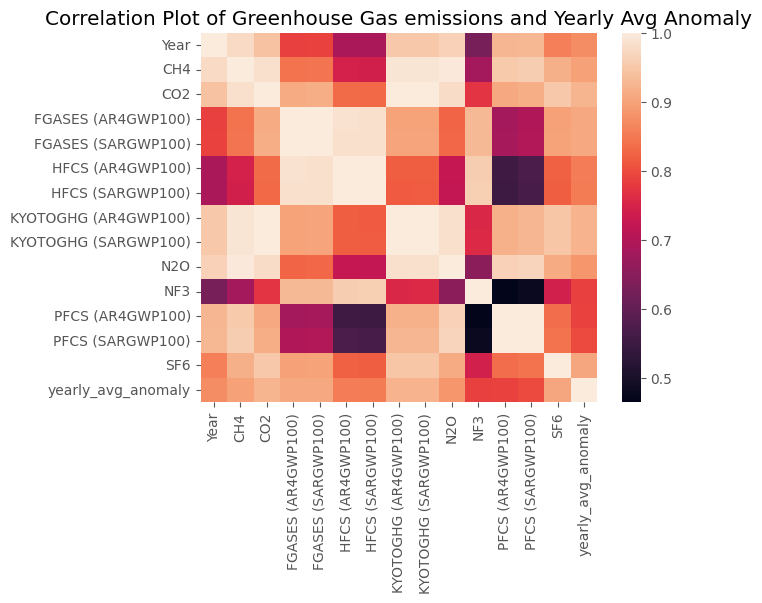

In [67]:
ghg_correlation_cols = [col for col in full_ghg_anomaly_df.columns if col not in months]
sns.heatmap(full_ghg_anomaly_df[ghg_correlation_cols].corr())
plt.title('Correlation Plot of Greenhouse Gas emissions and Yearly Avg Anomaly')
plt.show()

In [71]:
highest_corr_column = None
highest_corr_value = -1
cols_to_check = [col for col in ghg_correlation_cols if col not in ['yearly_avg_anomaly', 'Year']]

for col in cols_to_check:
    corr_value = full_ghg_anomaly_df['yearly_avg_anomaly'].corr(full_ghg_anomaly_df[col])
    print(f'Correlation of {col} emissions with temperature anomaly: {corr_value}')
    if corr_value > highest_corr_value:
        highest_corr_value = corr_value
        highest_corr_column = col

print(f'{highest_corr_column} emissions have the highest correlation with yearly average anomaly, with a correlation of {highest_corr_value}')

Correlation of CH4 emissions with temperature anomaly: 0.8988619076028566
Correlation of CO2 emissions with temperature anomaly: 0.9240029909774532
Correlation of FGASES (AR4GWP100) emissions with temperature anomaly: 0.9070296718217028
Correlation of FGASES (SARGWP100) emissions with temperature anomaly: 0.9087968617492858
Correlation of HFCS (AR4GWP100) emissions with temperature anomaly: 0.8537632706530416
Correlation of HFCS (SARGWP100) emissions with temperature anomaly: 0.852062321824396
Correlation of KYOTOGHG (AR4GWP100) emissions with temperature anomaly: 0.9215884939327806
Correlation of KYOTOGHG (SARGWP100) emissions with temperature anomaly: 0.9217042419000584
Correlation of N2O emissions with temperature anomaly: 0.8837215792227213
Correlation of NF3 emissions with temperature anomaly: 0.7864083911461084
Correlation of PFCS (AR4GWP100) emissions with temperature anomaly: 0.7898126695147472
Correlation of PFCS (SARGWP100) emissions with temperature anomaly: 0.79798362986870

In [78]:
correlation_cols = [col for col in ghg_correlation_cols if col != 'Year']
correlation_matrix = full_ghg_anomaly_df[correlation_cols].corr()
r_squared = correlation_matrix.loc['yearly_avg_anomaly', cols_to_check]**2
total_variance = full_ghg_anomaly_df['yearly_avg_anomaly'].var()
variance_explained = (r_squared * total_variance).sum()

print(f"The variance explained by the correlations is {variance_explained}, which is {variance_explained / total_variance}% of the total variance.")

The variance explained by the correlations is 1.448939343159237, which is 10.942272445301095% of the total variance.


While explaining ~11% of the variability may not seem like a lot, the complexity of the interactions that result in the climate of the earth would imply that there is  significance to the assertion that greenhouse gas emissions have an impact on the average temperature anomaly.

## **Further Questions to Consider**

* What caused the decline in temperature from around 1895 to 1915?
* What caused the massive rise from 1915 to 1945?